# Logistic regression on the iris flower dataset

In [2]:
# Code is based on Aurélien Geron's code
# https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb

try:
    import seaborn as sns
except:
    %pip install seaborn
    import seaborn as sns

try:
    import matplotlib.pyplot as plt
except:
    %pip install matplotlib
    import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

try:
    import jax
except:
    %pip install jax jaxlib
    import jax

import jax.numpy as jnp

try:
    from sklearn import datasets
except:
    %pip install scikit-learn
    from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

In [34]:
import os

LATEXIFY = "LATEXIFY" in os.environ

if LATEXIFY:
    import sys

    sys.path.append("scripts")
    from plot_utils import latexify, savefig

    latexify(width_scale_factor=1.1, fig_height=1.5)
SCATTER_SIZE = 10 if LATEXIFY else None

/home/patel_zeel/miniconda3/envs/probml_murphy/lib/python3.9/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


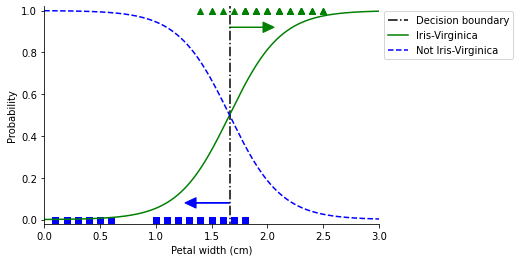

In [36]:
########################
# Initially use 1 feature, 2 classes

x = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(jnp.int32)  # 1 if Iris-Virginica, else 0'

logistic_regression = LogisticRegression(solver="lbfgs", C=1)
logistic_regression.fit(x, y)

x_new = jnp.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = logistic_regression.predict_proba(x_new)
decision_boundary = x_new[y_proba[:, 1] >= 0.5][0]


plt.figure()
plt.scatter(x[y == 0], y[y == 0], s=SCATTER_SIZE, c="b", marker="s")
plt.scatter(x[y == 1], y[y == 1], s=SCATTER_SIZE, c="g", marker="^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], color="black", linestyle="-.", label="Decision boundary")
plt.plot(x_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(x_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc="g", ec="g")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1, 1))
plt.axis([0, 3, -0.02, 1.02])
sns.despine()
if LATEXIFY:
    savefig("iris-logreg-1d_latexified.pdf")

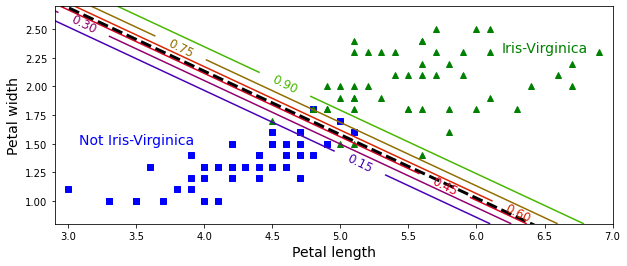

In [37]:
########################
# Now use 2 features, 2 classes

x = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(jnp.int32)  # 1 if Iris-Virginica, else 0

# penalty='none' is introduced in sklearn 0.21
# logistic_regression = LogisticRegression(solver="lbfgs", penalty='none')
# For older versions, we can simulate no regularization by using a large C
logistic_regression = LogisticRegression(solver="lbfgs", C=1000)
logistic_regression.fit(x, y)

x0, x1 = jnp.meshgrid(
    jnp.linspace(2.9, 7, 500),
    jnp.linspace(0.8, 2.7, 200),
)
x_new = jnp.c_[x0.ravel(), x1.ravel()]

y_proba = logistic_regression.predict_proba(x_new)

plt.figure(figsize=(10, 4))
plt.plot(x[y == 0, 0], x[y == 0, 1], "bs")
plt.plot(x[y == 1, 0], x[y == 1, 1], "g^")

zz_prob = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz_prob, cmap=plt.cm.brg)
left_right = jnp.array([2.9, 7])
boundary = (
    -(logistic_regression.coef_[0][0] * left_right + logistic_regression.intercept_[0])
    / logistic_regression.coef_[0][1]
)
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

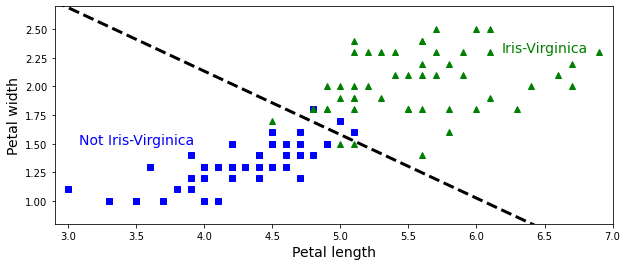

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(x[y == 0, 0], x[y == 0, 1], "bs")
plt.plot(x[y == 1, 0], x[y == 1, 1], "g^")

y_pred = logistic_regression.predict(x_new)
zz = y_pred.reshape(x0.shape)
left_right = jnp.array([2.9, 7])
boundary = (
    -(logistic_regression.coef_[0][0] * left_right + logistic_regression.intercept_[0])
    / logistic_regression.coef_[0][1]
)
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
# pml.savefig("iris-logreg-2d-2class-no-probs.pdf")
plt.show()

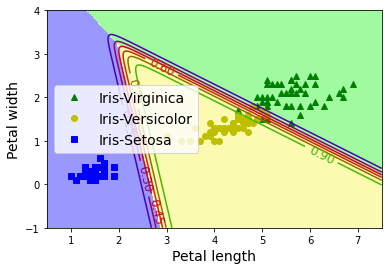

In [39]:
########################
# Now use 2 features and all 3 classes
x = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

# softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty="none")
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1000, random_state=42)
softmax_reg.fit(x, y)

x0, x1 = jnp.meshgrid(
    jnp.linspace(0.5, 7.5, 500),
    jnp.linspace(-1, 4, 200),
)
x_new = jnp.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(x_new)
y_predict = softmax_reg.predict(x_new)

zz_prob = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure()
plt.plot(x[y == 2, 0], x[y == 2, 1], "g^", label="Iris-Virginica")
# plt.plot(x[y==1, 0], x[y==1, 1], "bs", label="Iris-Versicolor")
# plt.plot(x[y==0, 0], x[y==0, 1], "yo", label="Iris-Setosa")
plt.plot(x[y == 1, 0], x[y == 1, 1], "yo", label="Iris-Versicolor")
plt.plot(x[y == 0, 0], x[y == 0, 1], "bs", label="Iris-Setosa")

custom_cmap = ListedColormap(["#9898ff", "#fafab0", "#a0faa0"])
# custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0']
# custom_cmap = ListedColormap(sns.color_palette())

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz_prob, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
# plt.axis([0, 7, 0, 3.5])
# pml.savefig("iris-logreg-2d-3class.pdf")
plt.show()

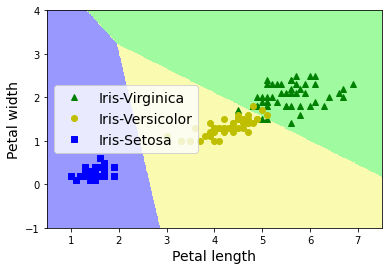

In [40]:
plt.figure()
plt.plot(x[y == 2, 0], x[y == 2, 1], "g^", label="Iris-Virginica")
# plt.plot(x[y==1, 0], x[y==1, 1], "bs", label="Iris-Versicolor")
# plt.plot(x[y==0, 0], x[y==0, 1], "yo", label="Iris-Setosa")
plt.plot(x[y == 1, 0], x[y == 1, 1], "yo", label="Iris-Versicolor")
plt.plot(x[y == 0, 0], x[y == 0, 1], "bs", label="Iris-Setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
# contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
# plt.axis([0, 7, 0, 3.5])
# pml.savefig("iris-logreg-2d-3class-noprobs.pdf")
plt.show()

# Get predictive distribution for some ambiguous test points
x = [[2.5, 3.0]]  # (1,2) array
y_probs = softmax_reg.predict_proba(x)
# print(jnp.round(y_probs, 2)) # [[0.53 0.37 0.1 ]]


########################
# Fit model and evaluate on separate test set

iris = datasets.load_iris()
# we only take the first two features to make problem harder
x = iris.data[:, :2]
# x = iris.data # use all data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', penalty='none')
logreg = LogisticRegression(solver="lbfgs", multi_class="multinomial", C=1000)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
errs = y_pred != y_test
nerrs = jnp.sum(errs)
# print("Made {} errors out of {}, on instances {}".format(nerrs, len(y_pred), jnp.where(errs)))
# With ndims=2: Made 10 errors out of 50, on instances

#  (array([ 4, 15, 21, 32, 35, 36, 40, 41, 42, 48]),)


err_rate_test = zero_one_loss(y_test, y_pred)
assert jnp.isclose(err_rate_test, nerrs / len(y_pred))
err_rate_train = zero_one_loss(y_train, logreg.predict(x_train))
# print("Error rates on train {:0.3f} and test {:0.3f}".format(err_rate_train, err_rate_test))
# Error rates on train 0.180 and test 0.200